In [1]:
import gumpy as gp
import numpy as np
import pywt

import sklearn
import os

C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import scipy
import scipy.io as sio

from scipy import linalg

import pandas as pd

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import classification_report , confusion_matrix #混淆矩阵

import xgboost
import lightgbm

from sklearn.cluster import KMeans

#one-hot使用
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import gc

%matplotlib inline

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
sample_rate = 256 #hz
origin_channel = 16 #5 channel eeg

#采集的通道
#共16 channel
#未使用的channel使用none代替
#reference:a study on performance increasing in ssvep based bci application
SAMPLE_CHANNEL = ['Pz' , 'PO3' , 'PO4' , 'O1' , 'O2' , 'Oz' , 'O9' , 'FP2' ,
                  'C4' , 'C6' , 'CP3' , 'CP1' ,
                  'CPZ' , 'CP2' , 'CP4' , 'PO8']

LABEL2STR = {0:'person_0' , 1:'person_1' , 2:'person_2'}

# 减去前多少秒数据 second
# 减去后多少秒数据 second
CLIP_FORWARD = 2
CLIP_BACKWARD = 1

# 单个小段的实验时长
trial_time = 3 #second
trial_offset = 0 #second
start_trial_time = 0 #真正的实验开始时刻
end_trial_time = 2 #真正的实验结束时刻(<trial_time)

#是否进行归一化
#reference:a study on performance increasing in ssvep based bci application
#IS_NORMALIZE = True

#是否进行滤波
#IS_FILTER = False
#EEG频率范围
#reference:a study on performance increasing in ssvep based bci application
LO_FREQ = 0.5
HI_FREQ = 40

#是否陷波
#IS_NOTCH = False
NOTCH_FREQ = 50 #陷波 工频



In [80]:
class EEG(gp.data.Dataset):
    def __init__(self , base_dir='none' , identifier='none' , **kwargs):
        super(EEG, self).__init__(**kwargs)
        
        self.base_dir = 'none'
        self.data_id = 'none'
        self.data_dir = 'none'
        self.data_type = 'EEG'
        self.data_name = 'EEG'
        
        
        # length of a trial (in seconds)
        self.trial_len = trial_time
        # motor imagery appears in interval (in seconds)
        self.mi_interval = [start_trial_time , end_trial_time]
        # idle perior prior to start of signal (in seconds)
        self.trial_offset = trial_offset
        # total length of a trial (in seconds)
        self.trial_total = self.trial_len
        # sampling frequency (in Hz)
        self.sampling_freq = sample_rate #gtec为256
    
    def _sep(self , data , label):
        train_data = []
        train_labels = []

        size = self.sampling_freq * self.trial_len
        data_length = data.shape[0]

        idx = 0
        
        while idx<data_length-size:
            train_data.append(data[idx : idx+size , :])
            train_labels.append(label)

            #no overlap
            idx = idx + size
        
        return np.array(train_data) , np.array(train_labels)
    
    def _butter_worth(self , data):
        b,a = scipy.signal.butter(4 , [LO_FREQ / sample_rate , HI_FREQ / sample_rate] , btype='bandpass')
    
        return np.array([scipy.signal.filtfilt(b , a , data[: , i]) for i in range(data.shape[1])]).reshape((-1 , origin_channel))
    
    def _notch(self , data):
        cutoff = NOTCH_FREQ #50
        Q = 30

        nyq = 0.5 * sample_rate
        w0 = cutoff / nyq

        b , a = scipy.signal.iirnotch(w0 , Q)

        return np.array([scipy.signal.filtfilt(b , a , data[: , i]) for i in range(data.shape[1])]).reshape((-1 , origin_channel))
    
    def _normalize(self , data):
        mean = np.mean(data, axis=0)
        std_dev = np.std(data, axis=0)
        
        return (data - mean) / std_dev
    
    def _load_data(self , filename):
        data = sio.loadmat(file_name=filename)['data_received'] #length*16 matrix
        
        #此通道没有采集 置为0
        for i in range(len(SAMPLE_CHANNEL)):
            if SAMPLE_CHANNEL[i] == 'none':
                data[: , i] = 0.0
        
        #删除前x秒和后x秒数据
        data = data[CLIP_FORWARD * self.sampling_freq : - CLIP_BACKWARD * self.sampling_freq]
                
        return data
    
    def _concatenate(self , eeg_matrix):
        return np.concatenate(eeg_matrix , axis=0)
    
    def _combine(self):
        person_0_filenames = os.listdir('real_data/eeg_11.24/circle/3/10hz/')
        person_1_filenames = os.listdir('real_data/eeg_11.24/circle/3/15hz/')
        person_2_filenames = os.listdir('real_data/eeg_11.24/circle/3/20hz/')
        person_3_filenames = os.listdir('real_data/eeg_11.24/circle/3/25hz/')


        person_0 = [self._load_data('real_data/eeg_11.24/circle/3/10hz/' + filename) for filename in person_0_filenames]
        person_1 = [self._load_data('real_data/eeg_11.24/circle/3/15hz/' + filename) for filename in person_1_filenames]
        person_2 = [self._load_data('real_data/eeg_11.24/circle/3/20hz/' + filename) for filename in person_2_filenames]
        person_3 = [self._load_data('real_data/eeg_11.24/circle/3/25hz/' + filename) for filename in person_3_filenames]


        person_0 = self._concatenate(person_0)
        person_1 = self._concatenate(person_1)
        person_2 = self._concatenate(person_2)
        person_3 = self._concatenate(person_3)

        #数据分段
        train_person_data_0 , train_person_labels_0 = self._sep(person_0 , label = 0)
        train_person_data_1 , train_person_labels_1 = self._sep(person_1 , label = 1)
        train_person_data_2 , train_person_labels_2 = self._sep(person_2 , label = 2)
        train_person_data_3 , train_person_labels_3 = self._sep(person_3 , label = 3)


        #产生索引并置乱
        idx_train_data = list(range(len(train_person_data_0) + len(train_person_data_1)+ len(train_person_data_2)+ len(train_person_data_3)))
        
        np.random.shuffle(idx_train_data)

        #合并数据
        train_data = np.concatenate((train_person_data_0 , train_person_data_1 , train_person_data_2 , train_person_data_3))
        train_labels = np.concatenate((train_person_labels_0 , train_person_labels_1 , train_person_labels_2 , train_person_labels_3))

        #将训练数据打乱
        train_data = train_data[idx_train_data]
        train_labels = train_labels[idx_train_data] ##self.labels
        
        #只使用下面的成员
        self.data = train_data
        self.labels = train_labels
                
        #=================
        #=================
        #合并为sequence
        train_data_sequence = np.reshape(train_data , newshape=(-1 , origin_channel)) #length*channel

        train_data_count = train_data.shape[0]

        #trial索引
        trial_idx = np.array([i*(self.sampling_freq * self.trial_len) for i in range(train_data_count)]) ##self.trial
        
        #构建子类成员
        self.raw_data = train_data_sequence
        self.trials = trial_idx
        
        #=================
        
        
    def load(self, **kwargs):
        self._combine()
     

In [81]:
dataset = EEG()
dataset.load()

In [82]:
print(dataset.data.shape , dataset.labels.shape)

(224, 768, 16) (224,)


In [8]:
def butter_worth(data , lo , hi , order=6):
    b,a = scipy.signal.butter(order , [lo / sample_rate , hi / sample_rate] , btype='bandpass')

    return np.array([scipy.signal.filtfilt(b , a , data[: , i]) for i in range(data.shape[1])]).reshape((-1 , origin_channel))

In [9]:
def alpha_subBP_features(data):
    alpha1 = butter_worth(data , 8.5 , 11.5)
    alpha2 = butter_worth(data , 9.0 , 12.5)    
    alpha3 = butter_worth(data , 9.5 , 11.5)    
    alpha4 = butter_worth(data , 8.0 , 10.5)   
    
    return np.array([alpha1 , alpha2 , alpha3 , alpha4])

def beta_subBP_features(data):
    beta1 = butter_worth(data , 14.0 , 30.0)
    beta2 = butter_worth(data , 16.0 , 17.0)    
    beta3 = butter_worth(data , 17.0 , 18.0)    
    beta4 = butter_worth(data , 18.0 , 19.0)    
    
    return np.array([beta1 , beta2 , beta3 , beta4])

def powermean(data):
    #官方demo跳4秒 前4秒为准备阶段
    return np.power(data[ : , 0] , 2).mean(), \
            np.power(data[ : , 1] , 2).mean(), \
            np.power(data[ : , 2] , 2).mean(), \
            np.power(data[ : , 3] , 2).mean(), \
            np.power(data[ : , 4] , 2).mean(), \
            np.power(data[ : , 5] , 2).mean(), \
            np.power(data[ : , 6] , 2).mean(), \
            np.power(data[ : , 7] , 2).mean(), \
            np.power(data[ : , 8] , 2).mean(), \
            np.power(data[ : , 9] , 2).mean(), \
            np.power(data[ : , 10] , 2).mean(), \
            np.power(data[ : , 11] , 2).mean(), \
            np.power(data[ : , 12] , 2).mean(), \
            np.power(data[ : , 13] , 2).mean(), \
            np.power(data[ : , 14] , 2).mean(), \
            np.power(data[ : , 15] , 2).mean()       

In [10]:
def log_subBP_feature_extraction(alpha , beta):
    
    power_1_a = powermean(alpha[0])
    power_2_a = powermean(alpha[1])
    power_3_a = powermean(alpha[2])
    power_4_a = powermean(alpha[3])
    
    power_1_b = powermean(beta[0])
    power_2_b = powermean(beta[1])
    power_3_b = powermean(beta[2])
    power_4_b = powermean(beta[3])
    
    X= np.array(
        [np.log(power_1_a) ,
         np.log(power_2_a) ,
         np.log(power_3_a) ,
         np.log(power_4_a) ,
         np.log(power_1_b) ,
         np.log(power_2_b) ,
         np.log(power_3_b) ,
         np.log(power_4_b)
        ]
        ).flatten()

    return X

In [11]:
def feature_extraction(data):
    n_features = 128
    X = np.zeros((data.shape[0] , n_features))
    
    for i , datum in enumerate(data):
        alpha = alpha_subBP_features(datum)
        beta = beta_subBP_features(datum)
            
        X[i, :] = log_subBP_feature_extraction(alpha , beta)

    return X

In [83]:
feature = feature_extraction(dataset.data)

C:\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [84]:
print(feature.shape , dataset.labels.shape)

(224, 128) (224,)


In [85]:
train_val_seg = 200

def confusion_mat(feature , labels , model):
    label_0 = 0
    label_1 = 0
    label_2 = 0
    #
    #调整一下 4种频率 4种label
    #
    for i in labels[train_val_seg : ]:
        if i == 0:
            label_0 = label_0+1
        elif i == 1:
            label_1 = label_1+1
        elif i == 2:
            label_2 = label_2+1
            
    print('real label_0:%d label_1:%d label_2:%d' % (label_0 , label_1 , label_2))
    
    print(confusion_matrix(labels[train_val_seg : ] , model.predict(feature[train_val_seg : ])))

In [86]:
svc = SVC(verbose=True)

In [87]:
svc.fit(feature[ : train_val_seg] , dataset.labels[ : train_val_seg])

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [88]:
svc.score(feature[train_val_seg : ] , dataset.labels[train_val_seg : ])

0.375

In [89]:
confusion_mat(feature , dataset.labels , svc)

real label_0:7 label_1:4 label_2:8
[[5 0 1 1]
 [3 0 1 0]
 [3 0 4 1]
 [1 4 0 0]]


In [90]:
# print(classification_report(dataset.labels[train_val_seg:] , svc.predict(feature[train_val_seg:])))

In [91]:
rf = RandomForestClassifier()

In [92]:
rf.fit(feature[:train_val_seg] , dataset.labels[:train_val_seg])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [93]:
rf.score(feature[train_val_seg:] , dataset.labels[train_val_seg:])

0.25

In [94]:
confusion_mat(feature , dataset.labels , rf)

real label_0:7 label_1:4 label_2:8
[[2 1 4 0]
 [2 1 1 0]
 [4 1 2 1]
 [1 2 1 1]]


In [95]:
adaboost = AdaBoostClassifier()

In [96]:
adaboost.fit(feature[:train_val_seg] , dataset.labels[:train_val_seg])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [97]:
adaboost.score(feature[train_val_seg:] , dataset.labels[train_val_seg:])

0.4166666666666667

In [98]:
confusion_mat(feature , dataset.labels , adaboost)

real label_0:7 label_1:4 label_2:8
[[2 0 3 2]
 [0 3 1 0]
 [3 2 3 0]
 [0 2 1 2]]


In [99]:
xgb = xgboost.XGBClassifier()

In [100]:
xgb.fit(feature[:train_val_seg] , dataset.labels[:train_val_seg])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [101]:
xgb.score(feature[train_val_seg:] , dataset.labels[train_val_seg:])

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.20833333333333334

In [102]:
confusion_mat(feature , dataset.labels , xgb)

real label_0:7 label_1:4 label_2:8
[[1 5 1 0]
 [0 1 2 1]
 [4 0 3 1]
 [1 4 0 0]]


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [103]:
lgbm = lightgbm.LGBMClassifier()

In [104]:
lgbm.fit(feature[:train_val_seg] , dataset.labels[:train_val_seg])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [105]:
lgbm.score(feature[train_val_seg:] , dataset.labels[train_val_seg:])

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.16666666666666666

In [106]:
confusion_mat(feature , dataset.labels , lgbm)

real label_0:7 label_1:4 label_2:8
[[1 4 2 0]
 [1 0 2 1]
 [5 0 2 1]
 [1 2 1 1]]


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Alpha and Beta sub-bands

C:\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [168]:


beta_bands = np.array(beta_subBP_features(dataset))

C:\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


## Method 1: logarithmic sub-band power

In [170]:
def log_subBP_feature_extraction(alpha , beta , trials , fs , w):
    n_features = 40
    X = np.zeros((len(trials) , n_features))
    
    for t , trial in enumerate(trials):
        # trial是一个scalar
        # t也是一个scalar
        power_1_a = powermean(alpha[0], trial, fs, w)
        power_2_a = powermean(alpha[1], trial, fs, w)
        power_3_a = powermean(alpha[2], trial, fs, w)
        power_4_a = powermean(alpha[3], trial, fs, w)
        
        power_1_b = powermean(beta[0], trial, fs, w)
        
        X[t, :] = np.array(
            [np.log(power_1_a) ,
             np.log(power_2_a) ,
             np.log(power_3_a) ,
             np.log(power_4_a) ,
             np.log(power_1_b) ]).flatten()

    return X

## Method 2: DWT
## no use

In [75]:
def dwt_features(data , trials , level , sampling_freq , w , n , wavelet):
    n_features = 24
    
    X = np.zeros((len(trials) , n_features))
    
    for t , trial in enumerate(trials):
        signals = data[trial + w[0] : trial + w[1]]
        
        coeffs_Pz  = pywt.wavedec(data = signals[:,0], wavelet=wavelet, level=level)
        coeffs_PO3 = pywt.wavedec(data = signals[:,1], wavelet=wavelet, level=level)
        coeffs_PO4 = pywt.wavedec(data = signals[:,2], wavelet=wavelet, level=level)
        coeffs_O1  = pywt.wavedec(data = signals[:,3], wavelet=wavelet, level=level)
        coeffs_O2  = pywt.wavedec(data = signals[:,4], wavelet=wavelet, level=level)
        coeffs_Oz  = pywt.wavedec(data = signals[:,5], wavelet=wavelet, level=level)
        coeffs_O9  = pywt.wavedec(data = signals[:,6], wavelet=wavelet, level=level)
        coeffs_FP2 = pywt.wavedec(data = signals[:,7], wavelet=wavelet, level=level)

        X[t, :] = np.array([
            np.std(coeffs_Pz [n]),   
            np.std(coeffs_PO3[n]),  
            np.std(coeffs_PO4[n]),   
            np.std(coeffs_O1 [n]),  
            np.std(coeffs_O2 [n]),  
            np.std(coeffs_Oz [n]),   
            np.std(coeffs_O9 [n]),  
            np.std(coeffs_FP2[n]),  
            
            np.mean(coeffs_Pz [n]**2),
            np.mean(coeffs_PO3[n]**2 ),
            np.mean(coeffs_PO4[n]**2 ),
            np.mean(coeffs_O1 [n]**2 ),
            np.mean(coeffs_O2 [n]**2),
            np.mean(coeffs_Oz [n]**2 ),
            np.mean(coeffs_O9 [n]**2 ),
            np.mean(coeffs_FP2[n]**2),
            
            np.mean(coeffs_Pz [n]),
            np.mean(coeffs_PO3[n]), 
            np.mean(coeffs_PO4[n]),
            np.mean(coeffs_O1 [n]),
            np.mean(coeffs_O2 [n]),
            np.mean(coeffs_Oz [n]),
            np.mean(coeffs_O9 [n]),
            np.mean(coeffs_FP2[n])]).flatten()
        
        return X

In [76]:
# 全trial
# 后续使用log特征
if False:
    w = [0 , sample_rate*trial_time]
    
    trials = dataset.trials
    fs = dataset.sampling_freq
    
    features1 = np.array(dwt_features(btr_data , trials , 5 , fs , w , 3 , 'db4'))
    features2 = np.array(dwt_features(btr_data , trials , 5 , fs , w , 4 , 'db4'))   
    
    features = np.concatenate((features1.T , features2.T)).T
    features -= np.mean(features)
    features_ = gp.signal.normalize(features , 'min_max')

NameError: name 'btr_data' is not defined

In [34]:
features.shape

(44, 50)

## Sequential Feature Selection

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.0s finished

[2018-11-28 16:11:38] Features: 1/12 -- score: 0.5066666666666667[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished

[2018-11-28 16:11:44] Features: 2/12 -- score: 0.5845238095238094[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s finished

[2018-11-28 16:11:50] Features: 3/12 -- score: 0.6316666666666666[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | el

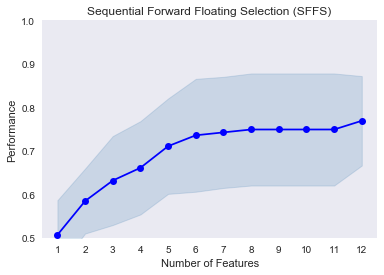

In [177]:
# Sequential Feature Selection Algorithm
#使用log 特征

feature_idx, cv_scores, algorithm , SequentialFeatureSelector , LinearDiscriminantAnalysis = gp.features.sequential_feature_selector(features, dataset.labels, 'LDA',  12 , 10, 'SFFS')

#选取6-12个特征 具体的特征个数在6-12之间
# feature_idx, cv_scores, algorithm , SequentialFeatureSelector , LinearDiscriminantAnalysis = gp.features.sequential_feature_selector(features, labels, 'LDA', (6,12) , 10, 'SFFS')

In [178]:
cv_scores

0.769047619047619

In [179]:
algorithm

'Sequential Forward Floating Selection (SFFS)'

## PCA

In [180]:
PCA = gp.features.PCA_dim_red(features , 0.95)

In [181]:
PCA.shape

(135, 2)

## training and classification

In [182]:
split_features = gp.split.shuffle_Split(features , dataset.labels , n_splits=10 , test_size=0.2 , random_state=0)

In [183]:
X_train = split_features[0]
X_test = split_features[1]

Y_train = split_features[2]
Y_test = split_features[3]

In [184]:
X_train.shape

(108, 80)

In [185]:
X_test.shape

(27, 80)

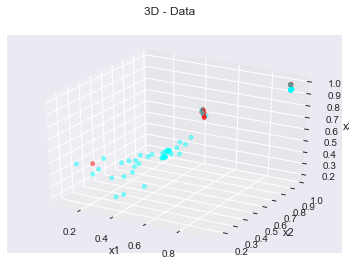

In [186]:
# PCA and plot in low-dimension

gp.plot.PCA('3D' , features , X_train , Y_train)

In [187]:
results , clf = gp.classify('LDA' , X_train , Y_train , X_test , Y_test)

In [188]:
print(results)
print(results.accuracy)

             precision    recall  f1-score   support

          0       0.40      0.67      0.50         6
          1       0.60      0.50      0.55        12
          2       0.43      0.33      0.38         9

avg / total       0.50      0.48      0.48        27

48.148148148148145


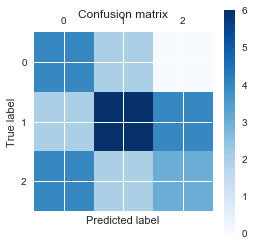

In [189]:
gp.plot.confusion_matrix(Y_test , results.pred)

In [97]:
results.pred

array([2, 3, 2, 0, 0, 2, 1, 1, 2, 3, 2])

In [98]:
results , _ = gp.classification.vote(X_train , Y_train , X_test , Y_test , 'hard' , False , (6,12))


C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [99]:
print(results)
print(results.accuracy)

             precision    recall  f1-score   support

          0       0.20      0.50      0.29         2
          1       0.00      0.00      0.00         4
          2       0.00      0.00      0.00         3
          3       0.00      0.00      0.00         2

avg / total       0.04      0.09      0.05        11

9.090909090909092


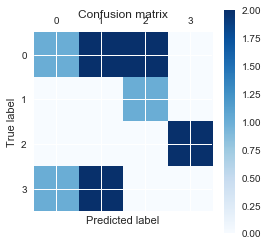

In [100]:
gp.plot.confusion_matrix(results.pred , Y_test)

In [ ]:
##查看数据信息
#一个trial的信号数据 index
display_idx = 20

plt.figure(figsize=(16,8))
plt.clf()
plt.plot(dataset.data[display_idx , 0:768 , 0 , 0], label='AF3')
plt.legend()
plt.title("Filtered Data{%s}" % LABEL2STR[dataset.labels[display_idx]])